In [41]:
# Import necessary libraries
import os
import re
import json
import logging
import warnings

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, util, losses, InputExample
from sentence_transformers.evaluation import InformationRetrievalEvaluator
from bayes_opt import BayesianOptimization
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm.autonotebook import tqdm, trange
from langchain_community.llms import Ollama
from langchain_core.prompts import PromptTemplate

# Set plotting style to cyberpunk
import mplcyberpunk
plt.style.use("cyberpunk")

# Suppress the specific FutureWarning from huggingface_hub
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub.file_download")


In [32]:
# Load the probes dataset
probes_df = pd.read_csv("../data/Catalog - Probes.csv")
probes_df = probes_df.drop(['Description'], axis=1)

# Split "Compatible_Systems" column
probes_df['Compatible_Systems'] = probes_df['Compatible_Systems'].str.split(', ')

# Split "Applications" column
probes_df['Applications'] = probes_df['Applications'].str.split(', ')

# Load the systems dataset
systems_df = pd.read_csv("../data/systems.csv")

# Split "compatible_probes" column
systems_df['compatible_probes'] = systems_df['compatible_probes'].str.split(', ')

# Print the head of the dataframes
probes_df.head()

,Manufacturer,Probe_Model,Cartridge_Connection,Compatible_Systems,Array_Type,Applications,Min_Frequency,Max_Frequency,Stock
0,ATL,C3,0,[HDI 5000],convex,"[abdominal, general]",3.0,3.0,0
1,ATL,C4-2,0,[HDI 5000],convex,"[abdominal, obstetric, gynecologic, general]",2.0,4.0,2
2,ATL,C5-2,0,"[HDI 1500, HDI 3000, HDI 3500, HDI 5000]",convex,"[abdominal, general]",2.0,5.0,7
3,ATL,C5-IVT,0,"[UM9 HDI, HDI 1500, HDI 3000, HDI 3500, HDI 5000]",convex,"[intracavitary, endovaginal, gynecological]",4.0,6.0,0
4,ATL,C7-4,0,"[UM9 HDI, HDI 1500, HDI 3000, HDI 5000]",convex,"[cardiac, vascular, general]",4.0,7.0,0


In [33]:
systems_df.head()

,ultrasound_system,manufacturer,compatible_probes
0,HDI 5000,ATL,"[C3, C4-2, C5-2, C5-IVT, C7-4, C8-4v, C9-5ICT,..."
1,HDI 1500,ATL,"[C5-2, C5-IVT, C7-4, C9-5ICT, L7-4]"
2,HDI 3000,ATL,"[C5-2, C5-IVT, C7-4, C8-4v, CL 10-5, CT8-4, L7-4]"
3,HDI 3500,ATL,"[C5-2, C5-IVT, C8-4v, CT8-4]"
4,UM9 HDI,ATL,"[C5-IVT, C7-4, L7-4]"


## Generating document corpus

In [35]:
# Function to generate probe descriptions and tags
def generate_probe_info(row):
    """
    This function takes a row from the probes_df DataFrame and generates lists of probe descriptions and tags.
    """
    descriptions = []
    tags = []

    # Manufacturer
    descriptions.append(f"The manufacturer of the {row['Probe_Model']} probe is {row['Manufacturer']}.")
    tags.append(frozenset(['probes', 'manufacturer', row['Manufacturer'], row['Probe_Model']]))

    # Cartridge Connection
    if row['Cartridge_Connection'] == 1:
        descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe has a variant with a cartridge connection.")
        tags.append(frozenset(['probes', row['Manufacturer'], row['Probe_Model'], 'connection']))

    # Compatible Systems
    compatible_systems = ', '.join(row['Compatible_Systems'])
    descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is compatible with the following systems: {compatible_systems}.")
    tags.append(frozenset(['probes', row['Manufacturer'], row['Probe_Model'], 'compatibility', compatible_systems]))

    # Array Type
    descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} is a {row['Array_Type']} array type probe.")
    tags.append(frozenset(['probes', row['Manufacturer'], row['Probe_Model'], 'array type']))

    # Applications
    applications = ', '.join(row['Applications'])
    descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is suitable for the following applications: {applications}.")
    tags.append(frozenset(['probes', row['Manufacturer'], row['Probe_Model'], "applications", applications]))

    # Stock
    if row['Stock'] > 0:
        descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is currently in stock and available for sale.")
    else:
        descriptions.append(f"The {row['Manufacturer']} {row['Probe_Model']} probe is currently out of stock or not available for sale.")
    tags.append(frozenset(['probes', row['Manufacturer'], row['Probe_Model'], 'stock']))

    # Frequency Range
    descriptions.append(f"The frequency range of the {row['Manufacturer']} {row['Probe_Model']} probe is {row['Min_Frequency']} - {row['Max_Frequency']} MHz.")
    tags.append(frozenset(['probes', row['Manufacturer'], row['Probe_Model'], 'frequency']))

    return descriptions, tags

# Function to generate system descriptions and tags
def generate_system_description(row):
    """
    This function takes a row from the systems_df DataFrame and generates lists of system descriptions and tags.
    """
    descriptions = []
    tags = []

    # System manufacturer
    description = f"The {row['ultrasound_system']} ultrasound system is made by {row['manufacturer']}."
    descriptions.append(description)
    tags.append(frozenset([row['manufacturer'], row['ultrasound_system'], 'manufacturer', 'systems']))

    # System compatible probes
    compatible_probes = ', '.join(row['compatible_probes'])
    description = f"The {row['manufacturer']} {row['ultrasound_system']} ultrasound system is compatible with the following {row['manufacturer']} probes: {compatible_probes}."
    descriptions.append(description)
    tags.append(frozenset([row['manufacturer'], row['ultrasound_system'], 'compatibility', 'systems', compatible_probes]))

    return descriptions, tags

# Apply the probe function and directly unpack into separate lists
probe_descriptions, probe_tags = zip(*probes_df.apply(generate_probe_info, axis=1))

# Apply the system function and directly unpack into separate lists
system_descriptions, system_tags = zip(*systems_df.apply(generate_system_description, axis=1))

# Flatten the lists since each element is a list of items
all_contents = [item for sublist in (probe_descriptions + system_descriptions) for item in sublist]
all_tags = [item for sublist in (probe_tags + system_tags) for item in sublist]

# Create a DataFrame from these lists
documents = pd.DataFrame({
    'content': all_contents,
    'tags': all_tags
})

documents.head()

,content,tags
0,The manufacturer of the C3 probe is ATL.,"(probes, ATL, C3, manufacturer)"
1,The ATL C3 probe is compatible with the follow...,"(compatibility, probes, HDI 5000, C3, ATL)"
2,The ATL C3 is a convex array type probe.,"(probes, array type, ATL, C3)"
3,The ATL C3 probe is suitable for the following...,"(abdominal, general, probes, applications, C3,..."
4,The ATL C3 probe is currently out of stock or ...,"(probes, ATL, C3, stock)"


## Generating queries for the documents using llama3

In [ ]:
# Load the Ollama LLM
llm = Ollama(model="llama3")

prompt_template = PromptTemplate(
    input_variables=["document"],
    template="""
Generate three concise questions that can be answered using the following information, similar to the example provided. Provide only the questions, numbered as follows:

1. [insert question here]
2. [insert question here]
3. [insert question here]

Example 1:
Information: The manufacturer of the C3 probe is ATL.
Questions:
1. Who is the manufacturer of the C3 probe?
2. Who makes the C3 transducer?
3. Is the C3 probe made by ATL?

Example 2:
Information: The G.E. RIC5-9D probe is compatible with the following systems: Voluson E6, Voluson E8, Voluson E10, LOGIQ S7, LOGIQ S8, Vivid E95, LOGIQ E9, LOGIQ E10.
Questions:
1. What systems are compatible with the G.E. RIC5-9D probe?
2. Does the G.E. RIC5-9D work with the Voluson E6 system?
3. Is the G.E. RIC5-9D transducer compatible with the LOGIQ S7 system?

Example 3:
Information: The Siemens Acuson 15L8W probe has a variant with a cartridge connection.
Questions:
1. Does the Siemens Acuson 15L8W probe have a cartridge connection?
2. What kind of connector does the Siemens Acuson 15L8W transducer use?
3. Does the Siemens Acuson 15L8W probe use a cartridge connector?

Example 4:
Information: The Philips C8-4v is a convex array type probe.
Questions:
1. What array type is the Philips C8-4v?
2. What type of transducer is the Philips C8-4v?
3. Is the Philips C8-4v a convex array probe?

Example 5:
Information: The ATL P6-3 probe is suitable for the following applications: cardiac, vascular, general.
Questions:
1. What can the ATL P6-3 probe be used for?
2. What are the applications of the ATL P6-3 probe?
3. Can the P6-3 probe be used for cardiac applications?

Example 6:
Information: The G.E. RAB2-5L probe is currently in stock and available for sale.
Questions:
1. Do you have any RAB2-5L probes by G.E. for sale?
2. Is the G.E. RAB2-5L probe in stock?
3. Are there any RAB2-5L transducers for sale?

Example 7:
Information: The frequency range of the ATL L10-5 probe is 5.0 - 10.0 MHz.
Questions:
1. What is the frequency range of the ATL L10-5 probe?
2. What is the maximum frequency range of the ATL L10-5 transducer?
3. What is the minimum frequency range of the ATL L10-5 probe?

Information:
{document}
"""
)

def extract_questions(response):
    pattern = r'\d+\.\s(.+?\?)'
    questions = re.findall(pattern, response)
    return questions

def generate_questions(text_chunk):
    prompt = prompt_template.format(document=text_chunk)
    output = llm(prompt)
    questions = extract_questions(output)
    return questions

# Generate questions for each document
tqdm.pandas(desc="Generating questions")
documents["questions"] = documents["content"].progress_apply(generate_questions)

In [51]:
# Create a new DataFrame by exploding the 'questions' column
questions_df = documents.explode('questions')

# Reset the index of the new DataFrame
questions_df = questions_df.reset_index(drop=True)

# Rename the 'questions' column to 'question'
questions_df = questions_df.rename(columns={'questions': 'question'})
questions_df.to_csv("../data/questions_docs_tags.csv")
questions_df

,content,tags,question
0,The manufacturer of the C3 probe is ATL.,"[probes, manufacturer, ATL, C3]",Who is the manufacturer of the C3 probe?
1,The manufacturer of the C3 probe is ATL.,"[probes, manufacturer, ATL, C3]",Is the manufacturer of the C3 probe ATL?
2,The manufacturer of the C3 probe is ATL.,"[probes, manufacturer, ATL, C3]",Who makes the C3 probe?
3,The ATL C3 probe is compatible with the follow...,"[probes, ATL, C3, compatibility, HDI 5000]",What systems is the ATL C3 probe compatible with?
4,The ATL C3 probe is compatible with the follow...,"[probes, ATL, C3, compatibility, HDI 5000]",Does the ATL C3 probe work with the HDI 5000 s...
...,...,...,...
1003,The Cypress Portable ultrasound system is made...,"[Siemens Acuson, Cypress Portable, manufacture...",Is the Cypress Portable system a product of Si...
1004,The Cypress Portable ultrasound system is made...,"[Siemens Acuson, Cypress Portable, manufacture...",What company manufactures the Cypress Portable...
1005,The Siemens Acuson Cypress Portable ultrasound...,"[Siemens Acuson, Cypress Portable, compatibili...",Which Siemens Acuson probes are compatible wit...
1006,The Siemens Acuson Cypress Portable ultrasound...,"[Siemens Acuson, Cypress Portable, compatibili...",Is the 7V3c probe compatible with the Siemens ...


## Filtering out the questions that are not relevant using llama3 followed by manual scoring



In [74]:
# Define the prompt template for grading questions
grading_prompt_template = PromptTemplate(
    input_variables=["content", "question"],
    template="""
    Given the content: "{content}"
    Can the following question be sufficiently answered?
    Question: "{question}"
    Your response should only consist of one number, either a 0 (meaning No) or 1 (meaning Yes).
    
    Example 1:
    Content: "The manufacturer of the C3 probe is ATL."
    Question: "Who is the manufacturer of the C3 probe?"
    Response: 1

    Example 2:
    Content: "Who manufactures the EPIQ 7 ultrasound system?"
    Question: "The Siemens Acuson 12L3 probe is compatible with the following systems: Juniper."
    Response: 0
    """
)

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Precompile the regular expression for efficiency
score_pattern = re.compile(r'\b[01]\b')

def grade_question(content, question):
    prompt = grading_prompt_template.format(content=content, question=question)
    response = llm(prompt)
    # Use the precompiled regular expression to find numbers in the response
    matches = score_pattern.findall(response)
    if matches:
        # Assuming the first match is the relevant score
        return int(matches[0])
    else:
        # Log the issue and return a default value
        logging.warning(f"No valid score found in response: {response}")
        return None  # or set a default value, or handle it in another way


# Apply the grade_question function to each row to create a new 'score' column
tqdm.pandas(desc="Scoring Questions")
questions_df['score'] = questions_df.progress_apply(lambda row: grade_question(row['content'], row['question']), axis=1)
print(questions_df.head())

Scoring Questions:   0%|          | 0/1008 [00:00<?, ?it/s]

                                             content  \
0           The manufacturer of the C3 probe is ATL.   
1           The manufacturer of the C3 probe is ATL.   
2           The manufacturer of the C3 probe is ATL.   
3  The ATL C3 probe is compatible with the follow...   
4  The ATL C3 probe is compatible with the follow...   

                                         tags  \
0             (ATL, manufacturer, C3, probes)   
1             (ATL, manufacturer, C3, probes)   
2             (ATL, manufacturer, C3, probes)   
3  (HDI 5000, ATL, probes, compatibility, C3)   
4  (HDI 5000, ATL, probes, compatibility, C3)   

                                            question  score  
0           Who is the manufacturer of the C3 probe?      1  
1           Is the manufacturer of the C3 probe ATL?      1  
2                            Who makes the C3 probe?      1  
3  What systems is the ATL C3 probe compatible with?      1  
4  Does the ATL C3 probe work with the HDI 5000 s...      

In [75]:
filtered_df = questions_df[questions_df['score'].isin([0, None])]
filtered_df

,content,tags,question,score
11,The ATL C3 probe is suitable for the following...,"(abdominal, general, ATL, probes, applications...",Are there any other uses for the ATL C3 transd...,0
12,The ATL C3 probe is currently out of stock or ...,"(ATL, C3, stock, probes)",Is the ATL C3 probe currently in stock?,0
13,The ATL C3 probe is currently out of stock or ...,"(ATL, C3, stock, probes)",Can you still purchase the ATL C3 probe?,0
14,The ATL C3 probe is currently out of stock or ...,"(ATL, C3, stock, probes)",Are there any ATL C3 probes available for sale?,0
22,The ATL C4-2 probe is compatible with the foll...,"(HDI 5000, C4-2, ATL, probes, compatibility)",Is the ATL C4-2 probe only used with HDI 5000 ...,0
...,...,...,...,...
881,The G.E. Vivid E95 ultrasound system is compat...,"(systems, G.E., Vivid E95, compatibility, RIC5...",Which G.E. probe is compatible with both the L...,0
896,The EPIQ 5 ultrasound system is made by Philips.,"(EPIQ 5, systems, Philips, manufacturer)",What company manufactures the EPIQ 5 transducer?,0
928,The Philips iE33 ultrasound system is compatib...,"(C5-1, C8-5, L12-3, S4-1, S4-2, systems, compa...","Are the C5-1, C8-5, L12-3, S4-1, and S4-2 prob...",0
988,The Siemens Acuson Juniper ultrasound system i...,"(systems, Siemens Acuson, compatibility, Junip...",Are all Siemens Acuson probes compatible with ...,0


In [76]:
#filtered_df.to_csv("../data/filtered_questions_for_correction.csv")

In [90]:
#corrected_questions_df = pd.read_csv("../data/corrected_questions.csv")

# Drop the old rows from questions_df
#fine_tuning_dataset = questions_df.drop(filtered_df.index)

# Append the corrected rows to the original DataFrame
#fine_tuning_dataset = pd.concat([fine_tuning_dataset, corrected_questions_df], ignore_index=True)
#fine_tuning_dataset = fine_tuning_dataset[fine_tuning_dataset['score'] == 1].drop(columns=['score'])
#fine_tuning_dataset



,content,tags,question
0,The manufacturer of the C3 probe is ATL.,"(ATL, manufacturer, C3, probes)",Who is the manufacturer of the C3 probe?
1,The manufacturer of the C3 probe is ATL.,"(ATL, manufacturer, C3, probes)",Is the manufacturer of the C3 probe ATL?
2,The manufacturer of the C3 probe is ATL.,"(ATL, manufacturer, C3, probes)",Who makes the C3 probe?
3,The ATL C3 probe is compatible with the follow...,"(HDI 5000, ATL, probes, compatibility, C3)",What systems is the ATL C3 probe compatible with?
4,The ATL C3 probe is compatible with the follow...,"(HDI 5000, ATL, probes, compatibility, C3)",Does the ATL C3 probe work with the HDI 5000 s...
...,...,...,...
993,The Siemens Acuson 15L8W probe is compatible w...,"frozenset({'Siemens Acuson', 'probes', 'compat...",Are there any other systems besides Sequoia th...
994,The frequency range of the Siemens Acuson 5C2 ...,"frozenset({'5C2', 'frequency', 'Siemens Acuson...",Is the frequency range of the Siemens Acuson 5...
995,The Siemens Acuson 9EVF4 probe is currently ou...,"frozenset({'stock', '9EVF4', 'Siemens Acuson',...",Is the Siemens Acuson 9EVF4 probe currently av...
996,The Siemens Acuson 9EVF4 probe is currently ou...,"frozenset({'stock', '9EVF4', 'Siemens Acuson',...",Can you purchase the Siemens Acuson 9EVF4 probe?


In [ ]:
# Generate unique IDs for queries and documents based on their content
#document_ids = {doc: idx for idx, doc in enumerate(fine_tuning_dataset['content'].unique())}
#fine_tuning_dataset['doc_id'] = fine_tuning_dataset['content'].map(document_ids)
#fine_tuning_dataset['query_id'] = range(len(fine_tuning_dataset))

#fine_tuning_dataset.to_pickle('../data/fine_tuning_dataset.pkl')

## Start here to import fine-tuning dataset

In [2]:
# Loading from Pickle
fine_tuning_dataset = pd.read_pickle('../data/fine_tuning_dataset.pkl')
fine_tuning_dataset = fine_tuning_dataset[fine_tuning_dataset['labels'] == 1.0]
fine_tuning_dataset

,question,content,labels,doc_id,query_id
0,What is the frequency range of the G.E. RIC5-9...,The frequency range of the G.E. RIC5-9D probe ...,1.0,0,0
4,What applications is the Philips C8-4v probe s...,The Philips C8-4v probe is suitable for the fo...,1.0,2,4
5,Is the Philips C5-2 probe currently available ...,The Philips C5-2 probe is currently in stock a...,1.0,3,5
7,Is the HDI 1500 ultrasound system made by ATL?,The HDI 1500 ultrasound system is made by ATL.,1.0,4,7
11,Is the ATL C4-2 probe used in general medicine?,The ATL C4-2 probe is suitable for the followi...,1.0,5,11
...,...,...,...,...,...
1916,Are there any Philips L17-5 probes available f...,The Philips L17-5 probe is currently in stock ...,1.0,195,1916
1917,Which ultrasound machine is the G.E. 348c tran...,The G.E. 348c probe is compatible with the fol...,1.0,313,1917
1920,What can the ATL C7-4 probe be used for?,The ATL C7-4 probe is suitable for the followi...,1.0,183,1920
1923,What kind of array is the ATL C8-4v?,The ATL C8-4v is a convex array type probe.,1.0,279,1923


In [3]:

tags_df = pd.read_csv("../data/questions_docs_tags.csv")
tags_df = tags_df.drop(columns=['Unnamed: 0'])
tags_df_unique = tags_df.groupby('content')['tags'].apply(lambda x: ','.join(x)).reset_index()
merged_df = pd.merge(fine_tuning_dataset, tags_df_unique[['content', 'tags']], on='content', how='left')
merged_df = merged_df[merged_df['labels'] == 1.0]
merged_df


,question,content,labels,doc_id,query_id,tags
0,What is the frequency range of the G.E. RIC5-9...,The frequency range of the G.E. RIC5-9D probe ...,1.0,0,0,"frozenset({'G.E.', 'frequency', 'RIC5-9D', 'pr..."
1,What applications is the Philips C8-4v probe s...,The Philips C8-4v probe is suitable for the fo...,1.0,2,4,"frozenset({'transvaginal, transrectal, gynecol..."
2,Is the Philips C5-2 probe currently available ...,The Philips C5-2 probe is currently in stock a...,1.0,3,5,"frozenset({'stock', 'C5-2', 'Philips', 'probes..."
3,Is the HDI 1500 ultrasound system made by ATL?,The HDI 1500 ultrasound system is made by ATL.,1.0,4,7,"frozenset({'manufacturer', 'systems', 'HDI 150..."
4,Is the ATL C4-2 probe used in general medicine?,The ATL C4-2 probe is suitable for the followi...,1.0,5,11,"frozenset({'C4-2', 'ATL', 'abdominal, obstetri..."
...,...,...,...,...,...,...
958,Are there any Philips L17-5 probes available f...,The Philips L17-5 probe is currently in stock ...,1.0,195,1916,"frozenset({'stock', 'L17-5', 'Philips', 'probe..."
959,Which ultrasound machine is the G.E. 348c tran...,The G.E. 348c probe is compatible with the fol...,1.0,313,1917,"frozenset({'G.E.', 'LOGIQ 700', 'probes', 'com..."
960,What can the ATL C7-4 probe be used for?,The ATL C7-4 probe is suitable for the followi...,1.0,183,1920,"frozenset({'C7-4', 'cardiac, vascular, general..."
961,What kind of array is the ATL C8-4v?,The ATL C8-4v is a convex array type probe.,1.0,279,1923,"frozenset({'ATL', 'array type', 'C8-4v', 'prob..."


## Evaluating pre-trained model performance

In [12]:
# Load the models
models = {
    'multi-qa-mpnet-base-dot-v1': SentenceTransformer('multi-qa-mpnet-base-dot-v1'),
    'all-mpnet-base-v2': SentenceTransformer('all-mpnet-base-v2'),
    'multi-qa-distilbert-cos-v1': SentenceTransformer('multi-qa-distilbert-cos-v1')
}

# Generate embeddings for the content and questions
embeddings = {}
for model_name, model in models.items():
    embeddings[model_name] = {
        'content': model.encode(merged_df['content'].tolist(), convert_to_tensor=True, show_progress_bar=False),
        'question': model.encode(merged_df['question'].tolist(), convert_to_tensor=True, show_progress_bar=False)
    }



You try to use a model that was created with version 3.0.0.dev0, however, your version is 3.0.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





In [13]:
def compute_rr(embeddings, ranking_method):
    results_df = merged_df.copy()
    results_df['absolute_rank'] = 0
    results_df['rr'] = 0.0

    for i, question in enumerate(merged_df['question']):
        relevant_doc = merged_df['content'].iloc[i]
        query_emb = embeddings['question'][i].unsqueeze(0)  # Add batch dimension

        if ranking_method == 'dot_score':
            scores = util.dot_score(query_emb, embeddings['content'])[0].cpu().tolist()
        elif ranking_method == 'cos_sim':
            scores = util.cos_sim(query_emb, embeddings['content'])[0].cpu().tolist()

        # Combine docs & scores
        doc_score_pairs = list(zip(merged_df['content'], scores))

        # Sort by decreasing score
        doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

        # Find the rank of the first relevant document
        matching_indices = [idx for idx, (doc, score) in enumerate(doc_score_pairs) if doc == relevant_doc]
        if len(matching_indices) > 0:
            rank = matching_indices[0] + 1
        else:
            rank = len(doc_score_pairs) + 1  # Relevant document not found

        # Calculate reciprocal rank
        rr = 1 / rank

        # Update the corresponding row in results_df
        results_df.at[i, 'absolute_rank'] = rank
        results_df.at[i, 'rr'] = rr

    return results_df

# Compute RR for each model and ranking method
results = {
    'multi-qa-mpnet-base-dot-v1': compute_rr(embeddings['multi-qa-mpnet-base-dot-v1'], 'dot_score'),
    'all-mpnet-base-v2': compute_rr(embeddings['all-mpnet-base-v2'], 'dot_score'),
    'multi-qa-distilbert-cos-v1': compute_rr(embeddings['multi-qa-distilbert-cos-v1'], 'cos_sim')
}

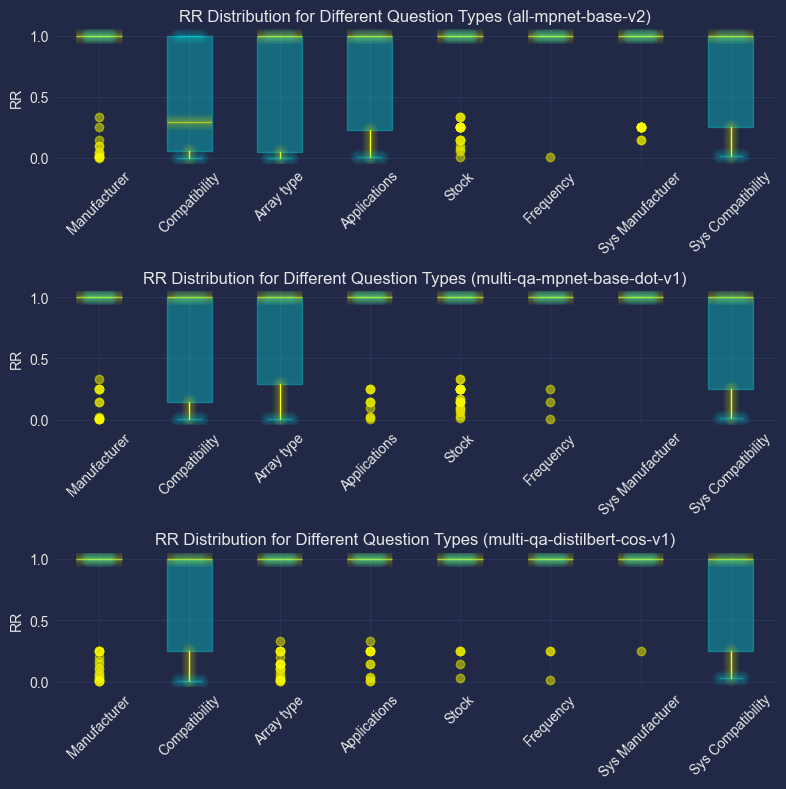

In [14]:
# Define the order of models
model_order = ['all-mpnet-base-v2', 'multi-qa-mpnet-base-dot-v1', 'multi-qa-distilbert-cos-v1']

# Filter RR values for different 'probes' and 'systems' question types
probe_types = ['manufacturer', 'compatibility', 'array type', 'applications', 'stock', 'frequency']
system_types = ['manufacturer', 'compatibility']

results_rr_by_type = {key: {ptype: df[df['tags'].apply(lambda x: 'probes' in x and ptype in x)]['rr'].dropna() for ptype in probe_types} for key, df in results.items()}

# Add 'systems' question types to the results
for key, df in results.items():
    results_rr_by_type[key].update({f'systems_{stype}': df[df['tags'].apply(lambda x: 'systems' in x and stype in x)]['rr'].dropna() for stype in system_types})

# Define the complete list of question types
all_types = probe_types + [f'systems_{stype}' for stype in system_types]
labels = [ptype.capitalize() for ptype in probe_types] + [f'Sys {stype.capitalize()}' for stype in system_types]

# Create the boxplot
fig, ax = plt.subplots(len(model_order), 1, figsize=(8, 8))  # Adjust the figure size

for i, model_key in enumerate(model_order):
    rr_by_type = results_rr_by_type[model_key]
    data = [rr_by_type[ptype] for ptype in all_types if ptype in rr_by_type]
    box = ax[i].boxplot(data, vert=True, patch_artist=True, medianprops=dict(color='yellow', alpha=0.5), boxprops=dict(facecolor='cyan', alpha=0.3, edgecolor='cyan'), capprops=dict(color='cyan', alpha=0.3), whiskerprops=dict(color='yellow'), flierprops=dict(markeredgecolor='yellow', markerfacecolor='yellow', alpha=0.3))
    ax[i].set_xticklabels(labels, rotation=45)
    ax[i].set_ylabel('RR')
    ax[i].set_title(f'RR Distribution for Different Question Types ({model_key})')

    mplcyberpunk.make_lines_glow(ax[i])

plt.tight_layout()
plt.show()

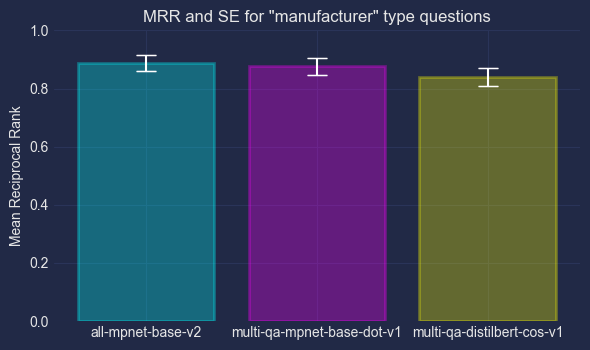

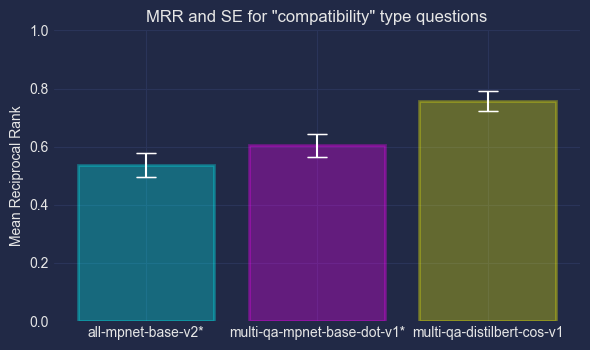

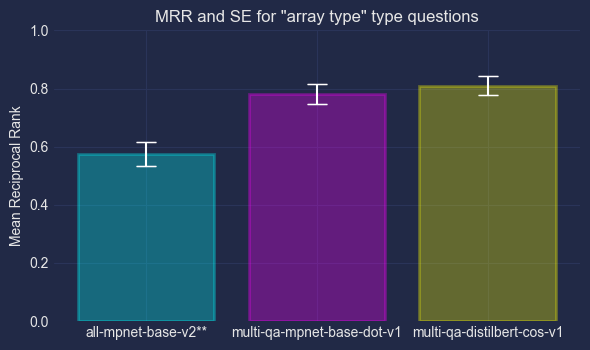

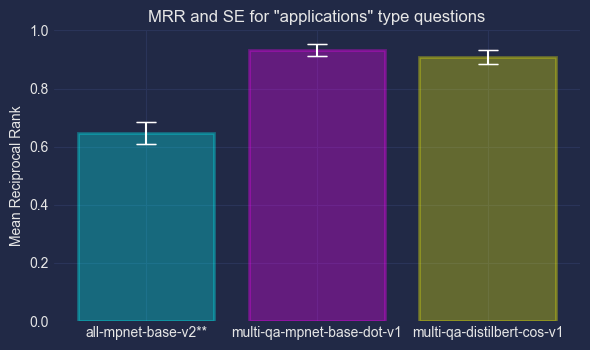

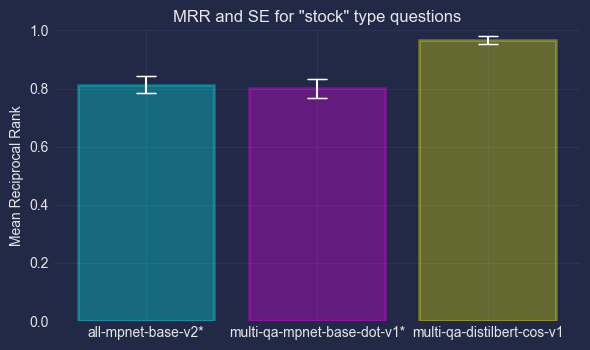

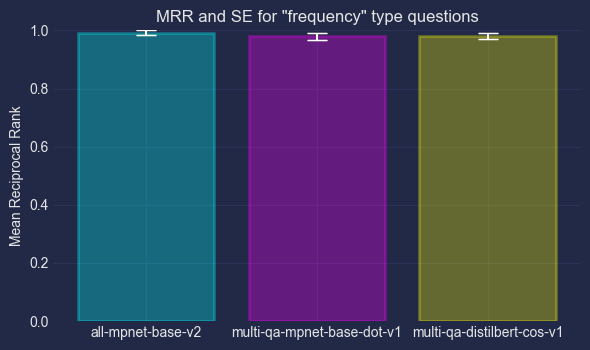

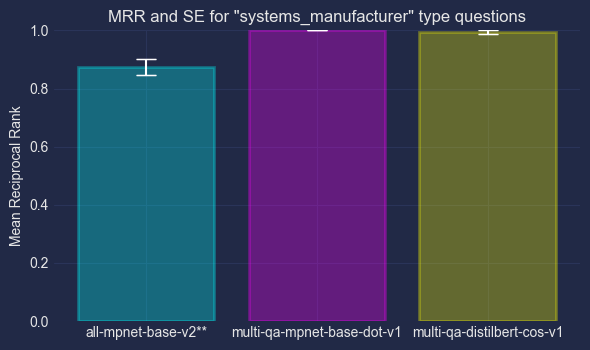

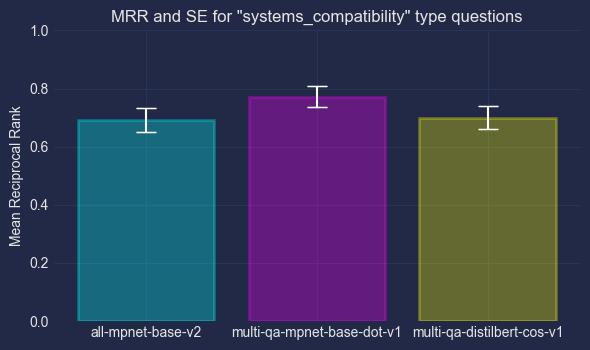

In [20]:
# Calculate means and standard errors
mean_rr_by_type = {}
se_rr_by_type = {}
tukey_results = {}

for ptype in all_types:
    mean_rr_by_type[ptype] = []
    se_rr_by_type[ptype] = []
    tukey_data = []
    for model_name in model_order:  # Use the defined model order
        rr_by_type = results_rr_by_type[model_name][ptype]
        mean_rr = np.mean(rr_by_type)
        se_rr = np.std(rr_by_type) / np.sqrt(len(rr_by_type))  # Standard Error of the mean
        mean_rr_by_type[ptype].append(mean_rr)
        se_rr_by_type[ptype].append(se_rr)
        tukey_data.extend([(ptype, model_name, rr) for rr in rr_by_type])

    # Prepare data for Tukey's HSD test
    tukey_df = pd.DataFrame(tukey_data, columns=['QuestionType', 'Model', 'RR'])
    tukey_result = pairwise_tukeyhsd(endog=tukey_df['RR'],
                                     groups=tukey_df['Model'],
                                     alpha=0.05)
    tukey_results[ptype] = tukey_result

# Colors for different models
colors = ['cyan', 'magenta', 'yellow']

for ptype in all_types:
    # Create a new figure for each question type
    fig, ax = plt.subplots(figsize=(6, 4)) 

    # Data for plotting
    means = mean_rr_by_type[ptype]
    errors = se_rr_by_type[ptype]
    x = np.arange(len(means))

    # Creating bar chart
    bars = ax.bar(x, means, yerr=errors, color=colors, capsize=7, alpha=0.3, linewidth=2, ecolor='white')
    for bar, color in zip(bars, colors):
        bar.set_edgecolor(color)
    ax.set_xticks(x)
    ax.set_xticklabels(model_order)
    ax.set_title(f'MRR and SE for "{ptype}" type questions')
    ax.set_ylim(0, 1)
    ax.set_ylabel('Mean Reciprocal Rank')
    ax.set_yticks(np.linspace(0, 1, 6))

    # Add cyberpunk-style effects
    mplcyberpunk.make_lines_glow(ax, alpha_line=0.6)

    # Add asterisks based on Tukey's HSD results
    tukey_result = tukey_results[ptype]
    asterisks_list = ['' for _ in model_order]
    for comparison in tukey_result.summary().data[1:]:
        group1, group2, meandiff, p_adj, lower, upper, reject = comparison
        if reject:  # If the null hypothesis is rejected
            if meandiff > 0:  # group1 has a higher mean than group2
                asterisks_list[model_order.index(group1)] += '*'
            elif meandiff < 0:  # group2 has a higher mean than group1
                asterisks_list[model_order.index(group2)] += '*'
    ax.set_xticklabels([f"{label}{asterisks}" for label, asterisks in zip(model_order, asterisks_list)])

    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust the bottom margin
    plt.savefig(f'../images/bar_chart_{ptype}.png', dpi=300, bbox_inches='tight')
    plt.show()

## Fine-tuning

In [4]:
# Remove duplicates and reset index
unique_corpus = fine_tuning_dataset.drop_duplicates(subset=['content']).reset_index(drop=True)

# Create document IDs
document_ids = {doc: idx for idx, doc in enumerate(unique_corpus['content'])}

# Create queries and query-document IDs
queries = {idx: row['question'] for idx, row in fine_tuning_dataset.iterrows()}
query_doc_ids = {idx: document_ids[row['content']] for idx, row in fine_tuning_dataset.iterrows() if row['labels'] == 1.0}

# Split the data into training, validation, and test sets
train_queries, temp_queries = train_test_split(list(queries.keys()), test_size=0.3, random_state=42)
val_queries, test_queries = train_test_split(temp_queries, test_size=0.5, random_state=42)

# Create relevant documents for validation and test sets
relevant_docs_val = {q_id: {query_doc_ids[q_id]} for q_id in val_queries if q_id in query_doc_ids}
relevant_docs_test = {q_id: {query_doc_ids[q_id]} for q_id in test_queries if q_id in query_doc_ids}

# Create corpus dictionary
corpus = {doc_id: doc for doc, doc_id in document_ids.items()}


In [5]:
class QADataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]

def get_content(query_id):
    doc_id = query_doc_ids.get(query_id, None)
    if doc_id is not None:
        return corpus[doc_id]
    else:
        return ""

train_examples = [InputExample(texts=[queries[q_id], get_content(q_id)]) for q_id in train_queries]
val_examples = [InputExample(texts=[queries[q_id], get_content(q_id)]) for q_id in val_queries]
test_examples = [InputExample(texts=[queries[q_id], get_content(q_id)]) for q_id in test_queries]

train_dataset = QADataset(train_examples)
val_dataset = QADataset(val_examples)
test_dataset = QADataset(test_examples)


In [6]:
# Function to remove and close all handlers from the logger
def close_logger(logger):
    handlers = logger.handlers[:]
    for handler in handlers:
        handler.close()
        logger.removeHandler(handler)

# Delete the existing training log file if it exists
log_file_path = '../models/bayes_opt/training.log'
if os.path.exists(log_file_path):
    close_logger(logging.getLogger('training_logger'))
    os.remove(log_file_path)

class LoggingInformationRetrievalEvaluator(InformationRetrievalEvaluator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.logger = logging.getLogger('training_logger')
        self.last_logged_epoch = -1

    def __call__(self, model, output_path=None, epoch=-1, steps=-1):
        if epoch != self.last_logged_epoch:
            results = super().__call__(model, output_path, epoch, steps)
            log_message = f"Epoch: {epoch}, Steps: {steps}\n"
            log_message += f"Information Retrieval Evaluation of the model on the {self.name} dataset:\n"
            log_message += f"Queries: {len(self.queries)}\nCorpus: {len(self.corpus)}\n\n"
            
            # Log only the key metrics
            key_metrics = [
                'validation-ir-eval_cosine_accuracy@1',
                'validation-ir-eval_cosine_accuracy@5',
                'validation-ir-eval_cosine_recall@1',
                'validation-ir-eval_cosine_recall@5',
                'validation-ir-eval_cosine_ndcg@10',
                'validation-ir-eval_cosine_mrr@10',
                'validation-ir-eval_cosine_map@100'
            ]
            for metric in key_metrics:
                if metric in results:
                    log_message += f"{metric}: {results[metric]}\n"
            
            self.logger.info(log_message)
            self.last_logged_epoch = epoch
            return results
        else:
            return super().__call__(model, output_path, epoch, steps)

# Setup logging configuration
def setup_logging(log_file_path):
    logger = logging.getLogger('training_logger')
    logger.setLevel(logging.INFO)
    fh = logging.FileHandler(log_file_path)
    fh.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    logger.addHandler(fh)
    return logger, fh

# Define the objective function
def objective(per_gpu_batch_size, weight_decay, learning_rate, warmup_steps, num_epochs):
    per_gpu_batch_size = int(per_gpu_batch_size)
    warmup_steps = int(warmup_steps)
    num_epochs = int(num_epochs)

    # Load the model
    model = SentenceTransformer('multi-qa-distilbert-cos-v1')

    # Define the loss function
    loss = losses.MultipleNegativesRankingLoss(model=model)

    # Setup logging
    logger, fh = setup_logging('../models/bayes_opt/training.log')

    # Instantiate the custom evaluators
    ir_evaluator_val = LoggingInformationRetrievalEvaluator(
        queries={q_id: queries[q_id] for q_id in val_queries},
        corpus=corpus,
        relevant_docs=relevant_docs_val,
        name="validation-ir-eval"
    )

    # Create DataLoader with the suggested batch size
    train_dataloader = DataLoader(train_dataset, batch_size=per_gpu_batch_size, shuffle=True)

    # Train the model with the evaluator
    model.fit(
        train_objectives=[(train_dataloader, loss)],
        evaluator=ir_evaluator_val,
        epochs=num_epochs,
        warmup_steps=warmup_steps,
        evaluation_steps=500,
        save_best_model=False,  # Do not save the model
        show_progress_bar=True,
        optimizer_params={'lr': learning_rate, 'weight_decay': weight_decay}
    )

    # Evaluate the model on the validation set
    results = ir_evaluator_val(model)
    
    # Close the logger handlers to release the file
    close_logger(logger)
    
    # Return the metric to be optimized, defaulting to 0 if 'validation-ir-eval_cosine_mrr@10' is not found
    return results.get('validation-ir-eval_cosine_mrr@10', 0)

# Define the search space
pbounds = {
    'per_gpu_batch_size': (16, 64),
    'weight_decay': (0, 0.3),
    'learning_rate': (1e-5, 5e-5),
    'warmup_steps': (0, 500),
    'num_epochs': (2, 5)
}

# Create a BayesianOptimization object
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# Run the optimization with reduced number of trials
optimizer.maximize(init_points=5, n_iter=15)

# Print the best hyperparameters
best_hyperparameters = optimizer.max['params']
print("Best hyperparameters: ", best_hyperparameters)

# Save the best hyperparameters to a file
with open('../models/bayes_opt/best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparameters, f)

|   iter    |  target   | learni... | num_ep... | per_gp... | warmup... | weight... |
-------------------------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

{'train_runtime': 181.3778, 'train_samples_per_second': 14.864, 'train_steps_per_second': 0.309, 'train_loss': 0.3011243002755301, 'epoch': 4.0}
| 1         | 0.9345    | 2.498e-05 | 4.852     | 51.14     | 299.3     | 0.04681   |


  0%|          | 0/24 [00:00<?, ?it/s]

{'train_runtime': 90.2361, 'train_samples_per_second': 14.939, 'train_steps_per_second': 0.266, 'train_loss': 0.572495182355245, 'epoch': 2.0}
| 2         | 0.9076    | 1.624e-05 | 2.174     | 57.58     | 300.6     | 0.2124    |


  0%|          | 0/52 [00:00<?, ?it/s]

{'train_runtime': 182.8944, 'train_samples_per_second': 14.741, 'train_steps_per_second': 0.284, 'train_loss': 0.36142991139338565, 'epoch': 4.0}
| 3         | 0.9347    | 1.082e-05 | 4.91      | 55.96     | 106.2     | 0.05455   |


  0%|          | 0/34 [00:00<?, ?it/s]

{'train_runtime': 83.3865, 'train_samples_per_second': 16.166, 'train_steps_per_second': 0.408, 'train_loss': 0.3781729305491728, 'epoch': 2.0}
| 4         | 0.9261    | 1.734e-05 | 2.913     | 41.19     | 216.0     | 0.08737   |


  0%|          | 0/46 [00:00<?, ?it/s]

{'train_runtime': 84.4542, 'train_samples_per_second': 15.961, 'train_steps_per_second': 0.545, 'train_loss': 0.21850511302118716, 'epoch': 2.0}
| 5         | 0.9329    | 3.447e-05 | 2.418     | 30.02     | 183.2     | 0.1368    |


  0%|          | 0/46 [00:00<?, ?it/s]

{'train_runtime': 81.9456, 'train_samples_per_second': 16.45, 'train_steps_per_second': 0.561, 'train_loss': 0.18444038474041483, 'epoch': 2.0}
| 6         | 0.9372    | 3.635e-05 | 2.227     | 30.1      | 183.1     | 0.1556    |


  0%|          | 0/52 [00:00<?, ?it/s]

{'train_runtime': 176.5368, 'train_samples_per_second': 15.272, 'train_steps_per_second': 0.295, 'train_loss': 0.220610471872183, 'epoch': 4.0}
| 7         | 0.9453    | 4.363e-05 | 4.582     | 56.09     | 107.4     | 0.1278    |


  0%|          | 0/52 [00:00<?, ?it/s]

{'train_runtime': 171.5594, 'train_samples_per_second': 15.715, 'train_steps_per_second': 0.303, 'train_loss': 0.2598581680884728, 'epoch': 4.0}
| 8         | 0.9551    | 3.632e-05 | 4.612     | 56.87     | 106.4     | 0.2091    |


  0%|          | 0/48 [00:00<?, ?it/s]

{'train_runtime': 174.0721, 'train_samples_per_second': 15.488, 'train_steps_per_second': 0.276, 'train_loss': 0.2994123299916585, 'epoch': 4.0}
| 9         | 0.9491    | 3.373e-05 | 4.506     | 57.85     | 106.2     | 0.2578    |


  0%|          | 0/39 [00:00<?, ?it/s]

{'train_runtime': 130.2781, 'train_samples_per_second': 15.521, 'train_steps_per_second': 0.299, 'train_loss': 0.32474605853740984, 'epoch': 3.0}
| 10        | 0.949     | 2.979e-05 | 3.522     | 56.55     | 106.4     | 0.179     |


  0%|          | 0/48 [00:00<?, ?it/s]

{'train_runtime': 181.3665, 'train_samples_per_second': 14.865, 'train_steps_per_second': 0.265, 'train_loss': 0.25574855009714764, 'epoch': 4.0}
| 11        | 0.9546    | 4.823e-05 | 4.612     | 57.65     | 108.5     | 0.1361    |


  0%|          | 0/39 [00:00<?, ?it/s]

{'train_runtime': 130.5205, 'train_samples_per_second': 15.492, 'train_steps_per_second': 0.299, 'train_loss': 0.31038594857240337, 'epoch': 3.0}
| 12        | 0.9486    | 3.723e-05 | 3.901     | 56.84     | 108.0     | 0.1621    |


  0%|          | 0/36 [00:00<?, ?it/s]

{'train_runtime': 134.8913, 'train_samples_per_second': 14.99, 'train_steps_per_second': 0.267, 'train_loss': 0.3753413094414605, 'epoch': 3.0}
| 13        | 0.9352    | 2.011e-05 | 3.35      | 59.15     | 107.8     | 0.1827    |


  0%|          | 0/65 [00:00<?, ?it/s]

{'train_runtime': 218.8083, 'train_samples_per_second': 15.402, 'train_steps_per_second': 0.297, 'train_loss': 0.21904801588792067, 'epoch': 5.0}
| 14        | 0.9485    | 5e-05     | 5.0       | 56.93     | 109.6     | 0.3       |


  0%|          | 0/24 [00:00<?, ?it/s]

{'train_runtime': 91.5147, 'train_samples_per_second': 14.73, 'train_steps_per_second': 0.262, 'train_loss': 0.4352372884750366, 'epoch': 2.0}
| 15        | 0.9209    | 2.323e-05 | 2.93      | 58.5      | 111.1     | 0.2766    |


  0%|          | 0/44 [00:00<?, ?it/s]

{'train_runtime': 83.8528, 'train_samples_per_second': 16.076, 'train_steps_per_second': 0.525, 'train_loss': 0.23672565546902744, 'epoch': 2.0}
| 16        | 0.922     | 2.153e-05 | 2.04      | 32.08     | 181.8     | 0.253     |


  0%|          | 0/24 [00:00<?, ?it/s]

{'train_runtime': 89.8087, 'train_samples_per_second': 15.01, 'train_steps_per_second': 0.267, 'train_loss': 0.4640875260035197, 'epoch': 2.0}
| 17        | 0.9222    | 2.291e-05 | 2.033     | 57.93     | 105.0     | 0.1316    |


  0%|          | 0/48 [00:00<?, ?it/s]

{'train_runtime': 176.9714, 'train_samples_per_second': 15.234, 'train_steps_per_second': 0.271, 'train_loss': 0.3607181708017985, 'epoch': 4.0}
| 18        | 0.9403    | 1.737e-05 | 4.675     | 57.35     | 107.0     | 0.02736   |


  0%|          | 0/52 [00:00<?, ?it/s]

{'train_runtime': 183.6405, 'train_samples_per_second': 14.681, 'train_steps_per_second': 0.283, 'train_loss': 0.30127299748934233, 'epoch': 4.0}
| 19        | 0.9399    | 1.716e-05 | 4.825     | 55.6      | 108.7     | 0.2361    |


  0%|          | 0/36 [00:00<?, ?it/s]

{'train_runtime': 132.111, 'train_samples_per_second': 15.305, 'train_steps_per_second': 0.272, 'train_loss': 0.360516177283393, 'epoch': 3.0}
| 20        | 0.941     | 2.8e-05   | 3.558     | 57.23     | 105.8     | 0.05252   |
Best hyperparameters:  {'learning_rate': 3.631692566303126e-05, 'num_epochs': 4.61248579441536, 'per_gpu_batch_size': 56.871775650047006, 'warmup_steps': 106.44852169800234, 'weight_decay': 0.20906624405054877}


In [22]:
# Use the best hyperparameter for batch size
batch_size = int(best_hyperparameters['per_gpu_batch_size'])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the final model with the best hyperparameters
def train_final_model(best_hyperparameters):
    per_gpu_batch_size = int(best_hyperparameters['per_gpu_batch_size'])
    weight_decay = best_hyperparameters['weight_decay']
    learning_rate = best_hyperparameters['learning_rate']
    warmup_steps = int(best_hyperparameters['warmup_steps'])
    num_epochs = int(best_hyperparameters['num_epochs'])

    # Load the model
    model = SentenceTransformer('multi-qa-distilbert-cos-v1')

    # Define the loss function
    loss = losses.MultipleNegativesRankingLoss(model=model)

    # Setup logging
    logger, fh = setup_logging('../models/best-IR-model/final_training.log')

    # Instantiate the custom evaluators
    ir_evaluator_val = LoggingInformationRetrievalEvaluator(
        queries={q_id: queries[q_id] for q_id in val_queries},
        corpus=corpus,
        relevant_docs=relevant_docs_val,
        name="validation-ir-eval"
    )

    # Create DataLoader with the suggested batch size
    train_dataloader = DataLoader(train_dataset, batch_size=per_gpu_batch_size, shuffle=True)

    # Train the model with the evaluator
    model.fit(
        train_objectives=[(train_dataloader, loss)],
        evaluator=ir_evaluator_val,
        epochs=num_epochs,
        warmup_steps=warmup_steps,
        evaluation_steps=500,
        save_best_model=True,  # Save the best model
        show_progress_bar=True,
        optimizer_params={'lr': learning_rate, 'weight_decay': weight_decay}
    )

    # Save the trained model
    model_save_path = '../models/best-IR-model'
    model.save(model_save_path)

    # Close the logger handlers to release the file
    close_logger(logger)

    print(f"Final model saved to {model_save_path}")

# Train the final model with the best hyperparameters
train_final_model(best_hyperparameters)


  0%|          | 0/52 [00:00<?, ?it/s]

{'train_runtime': 179.9444, 'train_samples_per_second': 14.982, 'train_steps_per_second': 0.289, 'train_loss': 0.24672205631549543, 'epoch': 4.0}


Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Final model saved to ../models/best-IR-model


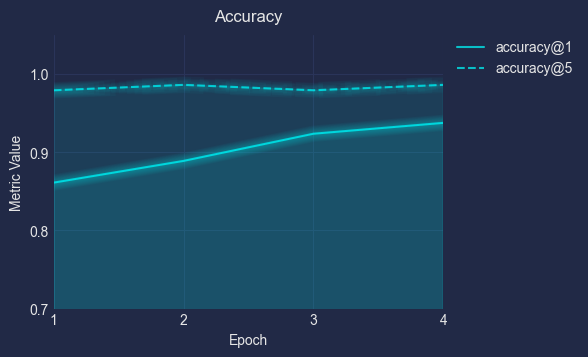

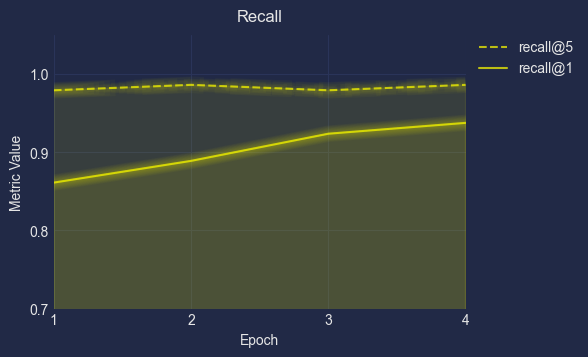

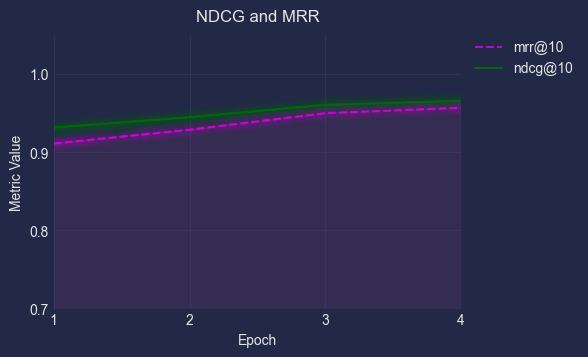

In [24]:
# Read the log file
with open('../models/best-IR-model/final_training.log', 'r') as f:
    log_contents = f.read()

# Extract metrics using regular expressions
epoch_pattern = r'Epoch: (\d+\.\d+)'
metric_pattern = r'(validation-ir-eval_cosine_(\w+))@(\d+): (\d+\.\d+)'

epochs = re.findall(epoch_pattern, log_contents)
metrics = re.findall(metric_pattern, log_contents)

# Create a dictionary to store the metric values for each epoch, grouped by metric type and top_k
metric_values = {}
for metric_name, metric_type, top_k, metric_value in metrics:
    if metric_type not in metric_values:
        metric_values[metric_type] = {}
    if top_k not in metric_values[metric_type]:
        metric_values[metric_type][top_k] = []
    metric_values[metric_type][top_k].append(float(metric_value))

# Define colors and line styles for each metric and top_k value
colors = {
    'accuracy@1': 'cyan', 'accuracy@5': 'cyan',
    'recall@1': 'yellow', 'recall@5': 'yellow',
    'mrr@10': 'magenta', 'ndcg@10': 'green'
}
line_styles = {
    'accuracy@1': '-', 'accuracy@5': '--',
    'recall@1': '-', 'recall@5': '--',
    'mrr@10': '-', 'ndcg@10': '--'
}

# Plot accuracy
plt.figure(figsize=(6, 4))
metric_type = 'accuracy'
for top_k, values in metric_values[metric_type].items():
    plt.plot(range(1, len(epochs) + 1), values, color=colors[f'{metric_type}@{top_k}'], linestyle=line_styles[f'{metric_type}@{top_k}'],
             label=f'{metric_type}@{top_k}', alpha=0.7)
plt.title('Accuracy', pad=10)  # Adjust title spacing
plt.ylabel('Metric Value')
plt.ylim(0.7, 1.05)  # Set y-axis limits from 0.7 to 1.05
plt.xlim(1, len(epochs))  # Set x-axis limits from 1 to the number of epochs
plt.yticks(np.arange(0.7, 1.05, 0.1))  # Set y-axis ticks every 0.1 starting from 0.7
plt.grid(True)
mplcyberpunk.add_glow_effects()
# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
plt.legend(unique_handles, unique_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Epoch')
plt.xticks(range(1, len(epochs) + 1, 1))  # Set epoch tick labels every epoch
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust subplot spacing
plt.show()

# Plot recall
plt.figure(figsize=(6, 4))
metric_type = 'recall'
for top_k, values in metric_values[metric_type].items():
    plt.plot(range(1, len(epochs) + 1), values, color=colors[f'{metric_type}@{top_k}'], linestyle=line_styles[f'{metric_type}@{top_k}'],
             label=f'{metric_type}@{top_k}', alpha=0.7)
plt.title('Recall', pad=10)  # Adjust title spacing
plt.ylabel('Metric Value')
plt.ylim(0.7, 1.05)  # Set y-axis limits from 0.7 to 1.05
plt.xlim(1, len(epochs))  # Set x-axis limits from 1 to the number of epochs
plt.yticks(np.arange(0.7, 1.05, 0.1))  # Set y-axis ticks every 0.1 starting from 0.7
plt.grid(True)
mplcyberpunk.add_glow_effects()
# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
plt.legend(unique_handles, unique_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Epoch')
plt.xticks(range(1, len(epochs) + 1, 1))  # Set epoch tick labels every epoch
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust subplot spacing
plt.show()

# Plot ndcg and mrr
plt.figure(figsize=(6, 4))
colors_ndcg_mrr = {'ndcg@10': 'green', 'mrr@10': 'magenta'}
line_styles_ndcg_mrr = {'ndcg@10': '-', 'mrr@10': '--'}
for metric_type in ['ndcg', 'mrr']:
    if metric_type in metric_values:
        for top_k, values in metric_values[metric_type].items():
            if top_k == '10':  # Only plot for top_k=10
                plt.plot(range(1, len(epochs) + 1), values, color=colors_ndcg_mrr[f'{metric_type}@{top_k}'],
                         linestyle=line_styles_ndcg_mrr[f'{metric_type}@{top_k}'], label=f'{metric_type}@{top_k}', alpha=0.7)
plt.title('NDCG and MRR', pad=10)  # Adjust title spacing
plt.ylabel('Metric Value')
plt.ylim(0.7, 1.05)  # Set y-axis limits from 0.7 to 1.05
plt.xlim(1, len(epochs))  # Set x-axis limits from 1 to the number of epochs
plt.yticks(np.arange(0.7, 1.05, 0.1))  # Set y-axis ticks every 0.1 starting from 0.7
plt.grid(True)
mplcyberpunk.add_glow_effects()
# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
plt.legend(unique_handles, unique_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Epoch')
plt.xticks(range(1, len(epochs) + 1, 1))  # Set epoch tick labels every epoch
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust subplot spacing
plt.show()

In [25]:
# Load your best model checkpoint
best_model_path = '../models/best-IR-model'
best_model = SentenceTransformer(best_model_path)

# Load the base pre-fine-tuning model and mpnet models
base_model = SentenceTransformer('multi-qa-distilbert-cos-v1')
mpnet_model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')
all_mpnet_model = SentenceTransformer('all-mpnet-base-v2')

You try to use a model that was created with version 3.0.0.dev0, however, your version is 3.0.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





In [67]:
# Create the evaluator
ir_evaluator = InformationRetrievalEvaluator(
    queries={q_id: queries[q_id] for q_id in test_queries},
    corpus=corpus,
    relevant_docs=relevant_docs_test,
    name="test-ir-eval"
)

# Evaluate the models
results_best_model = ir_evaluator(best_model)
results_base_model = ir_evaluator(base_model)
results_mpnet_model = ir_evaluator(mpnet_model)
results_all_mpnet_model = ir_evaluator(all_mpnet_model)

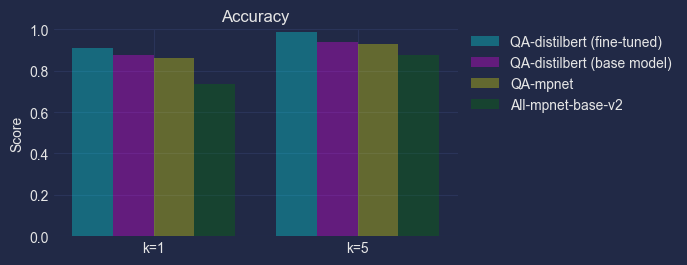

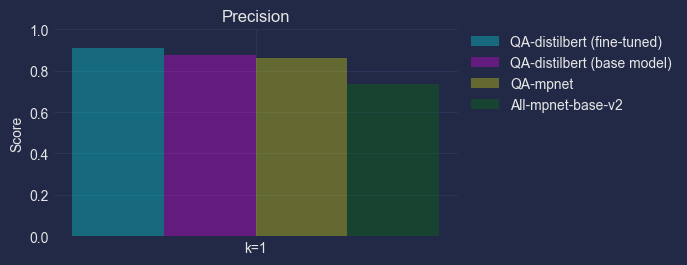

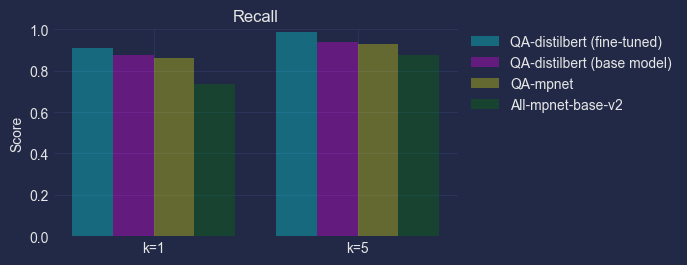

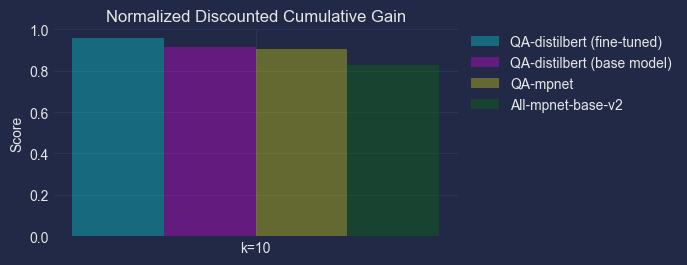

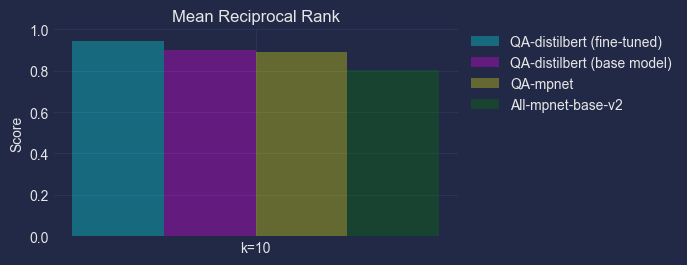

In [76]:
# Define the metrics and top_k values
metric_names = ['accuracy', 'precision', 'recall', 'ndcg', 'mrr']
top_k_values = {
    'accuracy': [1, 5],
    'precision': [1],
    'recall': [1, 5],
    'ndcg': [10],
    'mrr': [10]
}

# Create a list of model names
model_names = ['QA-distilbert (fine-tuned)', 'QA-distilbert (base model)', 'QA-mpnet', 'All-mpnet-base-v2']

# Define colors for each model
model_colors = {
    'QA-distilbert (fine-tuned)': 'cyan',
    'QA-distilbert (base model)': 'magenta',
    'QA-mpnet': 'yellow',
    'All-mpnet-base-v2': 'green'
}

# Iterate over each metric
for metric_name in metric_names:
    x = np.arange(len(top_k_values[metric_name]))  # Set the x-axis positions for the bars
    width = 0.2  # Width of the bars

    fig, ax = plt.subplots(figsize=(7, 3))

    for j, top_k in enumerate(top_k_values[metric_name]):
        metric_key = f'test-ir-eval_cosine_{metric_name}@{top_k}'
        
        # Extract the metric values for each model
        best_metric_values = results_best_model.get(metric_key, 0)
        base_metric_values = results_base_model.get(metric_key, 0)
        mpnet_metric_values = results_mpnet_model.get(metric_key, 0)
        all_mpnet_metric_values = results_all_mpnet_model.get(metric_key, 0)

        # Create the bar chart for the current metric
        ax.bar(x[j] - 1.5 * width, best_metric_values, width, color=model_colors[model_names[0]], label=model_names[0], alpha=0.3)
        ax.bar(x[j] - 0.5 * width, base_metric_values, width, color=model_colors[model_names[1]], label=model_names[1], alpha=0.3)
        ax.bar(x[j] + 0.5 * width, mpnet_metric_values, width, color=model_colors[model_names[2]], label=model_names[2], alpha=0.3)
        ax.bar(x[j] + 1.5 * width, all_mpnet_metric_values, width, color=model_colors[model_names[3]], label=model_names[3], alpha=0.3)

    # Set the x-axis labels and tick positions
    ax.set_xticks(x)
    ax.set_xticklabels([f'k={top_k}' for top_k in top_k_values[metric_name]])

    # Set the title and labels for the current subplot
    if metric_name == 'ndcg':
        ax.set_title('Normalized Discounted Cumulative Gain')
    elif metric_name == 'mrr':
        ax.set_title('Mean Reciprocal Rank')
    else:
        ax.set_title(metric_name.capitalize())
    ax.set_ylabel('Score')

    # Set y-axis limits and ticks
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.2))

    # Remove duplicate legend entries and show only model names in the correct order
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for model_name in model_names:
        if model_name in labels:
            unique_labels.append(model_name)
            unique_handles.append(handles[labels.index(model_name)])
    ax.legend(unique_handles, unique_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    # Adjust the layout and save the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'../images/{metric_name}_test_plot.png', dpi=300)
    plt.show()



In [77]:
# Combine results into a DataFrame
data = {
    'Metric': [
        'Accuracy@1', 'Accuracy@5', 'Precision@1', 'Recall@1', 'Recall@5', 'NDCG@10', 'MRR@10'
    ],
    'QA-distilbert (fine-tuned)': [
        results_best_model['test-ir-eval_cosine_accuracy@1'],
        results_best_model['test-ir-eval_cosine_accuracy@5'],
        results_best_model['test-ir-eval_cosine_precision@1'],
        results_best_model['test-ir-eval_cosine_recall@1'],
        results_best_model['test-ir-eval_cosine_recall@5'],
        results_best_model['test-ir-eval_cosine_ndcg@10'],
        results_best_model['test-ir-eval_cosine_mrr@10']
    ],
    'QA-distilbert (base model)': [
        results_base_model['test-ir-eval_cosine_accuracy@1'],
        results_base_model['test-ir-eval_cosine_accuracy@5'],
        results_base_model['test-ir-eval_cosine_precision@1'],
        results_base_model['test-ir-eval_cosine_recall@1'],
        results_base_model['test-ir-eval_cosine_recall@5'],
        results_base_model['test-ir-eval_cosine_ndcg@10'],
        results_base_model['test-ir-eval_cosine_mrr@10']
    ],
    'QA-mpnet': [
        results_mpnet_model['test-ir-eval_cosine_accuracy@1'],
        results_mpnet_model['test-ir-eval_cosine_accuracy@5'],
        results_mpnet_model['test-ir-eval_cosine_precision@1'],
        results_mpnet_model['test-ir-eval_cosine_recall@1'],
        results_mpnet_model['test-ir-eval_cosine_recall@5'],
        results_mpnet_model['test-ir-eval_cosine_ndcg@10'],
        results_mpnet_model['test-ir-eval_cosine_mrr@10']
    ],
    'All-mpnet-base-v2': [
        results_all_mpnet_model['test-ir-eval_cosine_accuracy@1'],
        results_all_mpnet_model['test-ir-eval_cosine_accuracy@5'],
        results_all_mpnet_model['test-ir-eval_cosine_precision@1'],
        results_all_mpnet_model['test-ir-eval_cosine_recall@1'],
        results_all_mpnet_model['test-ir-eval_cosine_recall@5'],
        results_all_mpnet_model['test-ir-eval_cosine_ndcg@10'],
        results_all_mpnet_model['test-ir-eval_cosine_mrr@10']
    ]
}

df = pd.DataFrame(data)
df.set_index('Metric', inplace=True)
df = df.applymap(lambda x: f'{x:.4f}')
df

C:\Users\denni\AppData\Local\Temp\ipykernel_18940\1729879047.py:46: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f'{x:.4f}')


,QA-distilbert (fine-tuned),QA-distilbert (base model),QA-mpnet,All-mpnet-base-v2
Metric,,,,
Accuracy@1,0.9103,0.8759,0.8621,0.7379
Accuracy@5,0.9862,0.9379,0.9310,0.8759
Precision@1,0.9103,0.8759,0.8621,0.7379
Recall@1,0.9103,0.8759,0.8621,0.7379
Recall@5,0.9862,0.9379,0.9310,0.8759
NDCG@10,0.9586,0.9142,0.9027,0.8276
MRR@10,0.9449,0.9020,0.8892,0.8028


In [79]:
df.to_latex('../images/performance_metrics_table.tex', caption='Performance Metrics for Each Embedding Model', label='tab:performance_metrics', float_format="%.4f")



In [81]:
num_documents = len(unique_corpus)
num_queries_total = len(queries)
num_queries_train = len(train_queries)
num_queries_val = len(val_queries)
num_queries_test = len(test_queries)

hyperparameters = {
    'per_gpu_batch_size': int(best_hyperparameters['per_gpu_batch_size']),
    'weight_decay': best_hyperparameters['weight_decay'],
    'learning_rate': best_hyperparameters['learning_rate'],
    'warmup_steps': int(best_hyperparameters['warmup_steps']),
    'num_epochs': int(best_hyperparameters['num_epochs'])
}

performance_metrics = {
    'Accuracy@1': results_best_model['test-ir-eval_cosine_accuracy@1'],
    'Accuracy@5': results_best_model['test-ir-eval_cosine_accuracy@5'],
    'Precision@1': results_best_model['test-ir-eval_cosine_precision@1'],
    'Recall@1': results_best_model['test-ir-eval_cosine_recall@1'],
    'Recall@5': results_best_model['test-ir-eval_cosine_recall@5'],
    'NDCG@10': results_best_model['test-ir-eval_cosine_ndcg@10'],
    'MRR@10': results_best_model['test-ir-eval_cosine_mrr@10']
}

# Combine all data into a single DataFrame for CSV export
data = {
    'Category': [
        'Number of Documents', 'Number of Queries (Total)', 'Number of Queries (Training)',
        'Number of Queries (Validation)', 'Number of Queries (Test)', 'Best Hyperparameters', 'Performance Metrics'
    ],
    'Details': [
        num_documents, num_queries_total, num_queries_train, num_queries_val, num_queries_test,
        best_hyperparameters, performance_metrics
    ]
}

df = pd.DataFrame(data)

def format_dict(data):
    if isinstance(data, dict):
        return '\n'.join([f"{key}: {value}" for key, value in data.items()])
    return data

df['Details'] = df['Details'].apply(format_dict)
df


,Category,Details
0,Number of Documents,324
1,Number of Queries (Total),963
2,Number of Queries (Training),674
3,Number of Queries (Validation),144
4,Number of Queries (Test),145
5,Best Hyperparameters,learning_rate: 3.631692566303126e-05\nnum_epoc...
6,Performance Metrics,Accuracy@1: 0.9103448275862069\nAccuracy@5: 0....


In [82]:
num_documents = len(unique_corpus)
num_queries_total = len(queries)
num_queries_train = len(train_queries)
num_queries_val = len(val_queries)
num_queries_test = len(test_queries)

hyperparameters = {
    'per_gpu_batch_size': int(best_hyperparameters['per_gpu_batch_size']),
    'weight_decay': best_hyperparameters['weight_decay'],
    'learning_rate': best_hyperparameters['learning_rate'],
    'warmup_steps': int(best_hyperparameters['warmup_steps']),
    'num_epochs': int(best_hyperparameters['num_epochs'])
}

performance_metrics = {
    'Accuracy@1': results_best_model['test-ir-eval_cosine_accuracy@1'],
    'Accuracy@5': results_best_model['test-ir-eval_cosine_accuracy@5'],
    'Precision@1': results_best_model['test-ir-eval_cosine_precision@1'],
    'Recall@1': results_best_model['test-ir-eval_cosine_recall@1'],
    'Recall@5': results_best_model['test-ir-eval_cosine_recall@5'],
    'NDCG@10': results_best_model['test-ir-eval_cosine_ndcg@10'],
    'MRR@10': results_best_model['test-ir-eval_cosine_mrr@10']
}

# Combine all data into a single string for text file export
data = {
    'Number of Documents': num_documents,
    'Number of Queries (Total)': num_queries_total,
    'Number of Queries (Training)': num_queries_train,
    'Number of Queries (Validation)': num_queries_val,
    'Number of Queries (Test)': num_queries_test,
    'Best Hyperparameters': hyperparameters,
    'Performance Metrics': performance_metrics
}

def format_dict(data):
    if isinstance(data, dict):
        return '\n'.join([f"{key}: {value}" for key, value in data.items()])
    return str(data)

# Create the content for the text file
content = "\n\n".join([f"{key}:\n{format_dict(value)}" for key, value in data.items()])

# Define the text file name
text_file_path = '../docs/model_metrics.txt'

# Write the content to the text file
with open(text_file_path, 'w') as file:
    file.write(content)

print(f"Model metrics have been written to {text_file_path}")

Model metrics have been written to ../docs/model_metrics.txt
